In [94]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from constants import ATR_ABNORMALITY_COLUMN
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (60,10)


# mutual information
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [2]:
data_manager = DataManager()

In [78]:
coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT", "BNBUSDT", "XRPUSDT"]
feature = "close_pct"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"

In [4]:
main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnromal_timestamps = main_1h_df[main_1h_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [5]:
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]

# Join close_pct columns of all coins togther

In [71]:
def join_dataframes(coin_data_list, shift):
    df = pd.DataFrame(index=coin_data_list[0].df.index)

    for coin_data in coin_data_list:
        df = df.join(coin_data.df.shift(shift)[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")

    df.rename(columns={"close_pct":f"close_pct_{coin_data_list[0].coin_symbol}"}, inplace=True)    
    df.dropna(inplace=True)
    df.drop(columns=["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

In [76]:
df = join_dataframes(coin_data_list=coin_data_list, shift=0)

In [77]:
df

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT,close_pct_LTCUSDT,close_pct_BNBUSDT,close_pct_XRPUSDT
timestamp,,,,,,
2018-05-04 08:12:00,0.000447,0.001985,-0.002497,0.002235,-0.000062,0.800000
2018-05-04 08:13:00,0.003085,0.001918,0.000935,0.002540,0.000950,0.011111
2018-05-04 08:14:00,0.000000,0.000038,0.000055,0.001421,0.000103,0.021967
2018-05-04 08:15:00,-0.001469,-0.003677,-0.001017,-0.000494,-0.003096,-0.021280
2018-05-04 08:16:00,0.000449,0.003362,-0.002201,-0.003334,-0.000545,0.021501
...,...,...,...,...,...,...
2021-06-24 09:28:00,0.000537,0.000052,0.000669,0.000681,0.000693,0.000000
2021-06-24 09:28:00,0.000007,0.000268,0.000669,0.000681,0.000693,0.000000
2021-06-24 09:28:00,0.000007,0.000052,0.000669,0.000681,0.000693,0.000000


# Create correl df

In [116]:
def mutual_information(a, b):
    return mutual_info_regression(a.reshape(-1,1), b, discrete_features = False )[0]

In [9]:
# resampled_list = list(df.resample(rule="1h"))
# alltime_correlation_matrix_list, abnormal_correlation_matrix_list = [],[]

# skipping_counter = 0
# for timestamp, temp_df in resampled_list:
        
#     if temp_df.empty:
#         skipping_counter += 1
#         continue
#     temp_correl_matrix = temp_df.corr(method="pearson").to_numpy()
#     if np.any(np.isnan(temp_correl_matrix)):
#         skipping_counter += 1
#         continue

#     if timestamp in main_abnromal_timestamps:
#         abnormal_correlation_matrix_list.append(temp_correl_matrix)
    
#     alltime_correlation_matrix_list.append(temp_correl_matrix)
# # transfrom to np.array
# abnormal_correlation_matrix_list = np.array(abnormal_correlation_matrix_list)
# alltime_correlation_matrix_list = np.array(alltime_correlation_matrix_list)
# # print skipping precent
# print(f"skipping precent {(skipping_counter/len(resampled_list))*100} %")

In [106]:
def get_correl_matrix_list(df, method = 'spearman'):
    resampled_list = list(df.resample(rule="1h"))
    alltime_correlation_matrix_list, abnormal_correlation_matrix_list = [],[]

    skipping_counter = 0
    for timestamp, temp_df in resampled_list:
            
        if temp_df.empty:
            skipping_counter += 1
            continue
        try:
            temp_correl_matrix = temp_df.corr(method=method).to_numpy()
        except:
            skipping_counter += 1
            continue
        
        if np.any(np.isnan(temp_correl_matrix)):
            skipping_counter += 1
            continue
        
        if timestamp in main_abnromal_timestamps:
            abnormal_correlation_matrix_list.append(temp_correl_matrix)
        
        alltime_correlation_matrix_list.append(temp_correl_matrix)

    
    # transfrom to np.array
    abnormal_correlation_matrix_list = np.array(abnormal_correlation_matrix_list)
    alltime_correlation_matrix_list = np.array(alltime_correlation_matrix_list)
    # print skipping precent
    print(f"skipping precent {(skipping_counter/len(resampled_list))*100} %")
    return alltime_correlation_matrix_list, abnormal_correlation_matrix_list

# mutual info

In [117]:
alltime_mi_matrix_list, abnormal_mi_matrix_list = get_correl_matrix_list(df, method=mutual_information)

skipping precent 0.29422448238285503 %


# correl

In [107]:
alltime_correlation_matrix_list, abnormal_correlation_matrix_list = get_correl_matrix_list(df)

skipping precent 0.3051216854340719 %


In [109]:
def plot_heatmap(correl_df, title, shift = 0):
    mean_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=correl_df)

    fig_size = max(len(df.columns), 10)
    sn.set(rc={"figure.figsize":tuple([fig_size]*2)})
    title = f"Settings - feature:{feature} | time-frame:{kline_size} | main-coin:{main_coin_symbol} | shift:{shift}\n" + title

    sn.heatmap(mean_corr_df, annot=True).set(title=title);

# def plot_heatmap(correl_df, title, shift):
#     mean_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=correl_df)

#     fig_size = max(len(df.columns), 10)
#     sn.set(rc={"figure.figsize":tuple([fig_size]*2)})
#     title = f"Settings - feature:{feature} | time-frame:{kline_size} | main-coin:{main_coin_symbol} | shift:{shift}\n" + title

#     sn.heatmap(mean_corr_df, annot=True).set(title=title);


In [103]:
def plot_heatmap_master(coin_data_list, correl_method = None, shift = 0):
    df = join_dataframes(coin_data_list=coin_data_list, shift=shift)
    alltime_correl_matrix_list, abnormal_correl_matrix_list = get_correl_matrix_list(df, method=correl_method)

    fig, axes = plt.subplots(1, 3)
    fig.suptitle(f"Settings - feature:{feature} | time-frame:{kline_size} | main-coin:{main_coin_symbol} | shift:{shift}\n")
    # func_to_run_str = str(func_to_run)[10:14]
    func_to_run_str = "Mean"
    axes[0].set_title(f"alltime {func_to_run_str} of 1min correlation")
    axes[1].set_title(f"abnormal {func_to_run_str} of 1min correlation")
    axes[2].set_title(f"abnromal - alltime")

    alltime_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=alltime_correl_matrix_list.mean(axis=0))
    abnomral_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=abnormal_correl_matrix_list.mean(axis=0))
    diff_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=abnormal_correl_matrix_list.mean(axis=0) - alltime_correl_matrix_list.mean(axis=0))
    sn.heatmap(alltime_corr_df, ax = axes[0],annot=True);
    sn.heatmap(abnomral_corr_df, ax = axes[1], annot=True);
    sn.heatmap(diff_df, ax = axes[1], annot=True);


skipping precent 0.2905920813657828 %
<ipython-input-103-00422c43b801>:13: RuntimeWarning: Mean of empty slice.
  alltime_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=alltime_correl_matrix_list.mean(axis=0))
/Users/guyvandam/miniforge3/envs/tensorflow/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-103-00422c43b801>:14: RuntimeWarning: Mean of empty slice.
  abnomral_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=abnormal_correl_matrix_list.mean(axis=0))
<ipython-input-103-00422c43b801>:15: RuntimeWarning: Mean of empty slice.
  diff_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=abnormal_correl_matrix_list.mean(axis=0) - alltime_correl_matrix_list.mean(axis=0))
/Users/guyvandam/miniforge3/envs/tensorflow/lib/python3.8/site-packages/seaborn/matrix.py:194: RuntimeWarning: All-NaN 

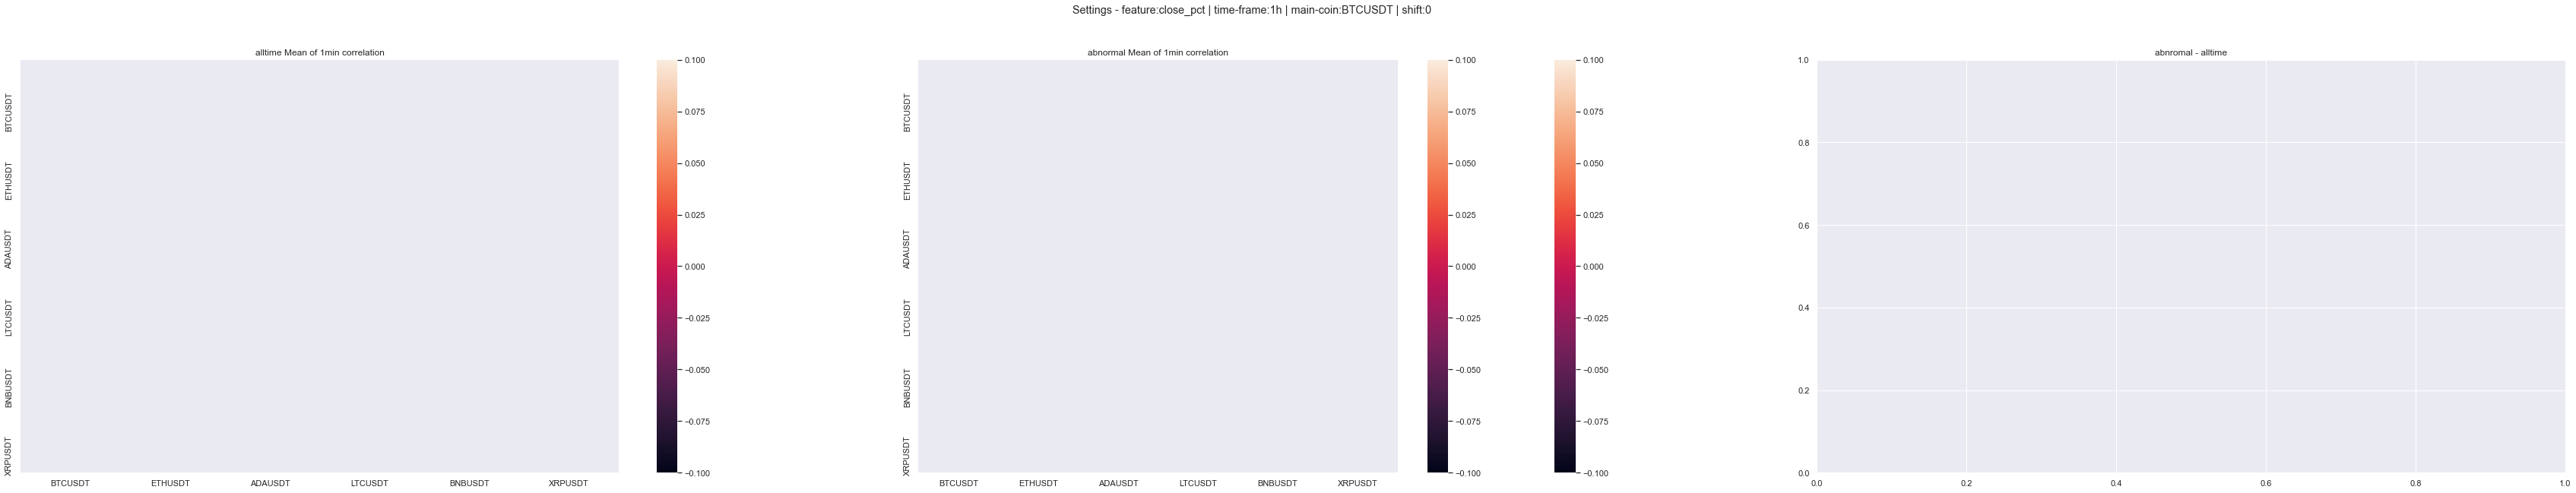

In [104]:
plot_heatmap_master(coin_data_list)

# Pearson Correlation

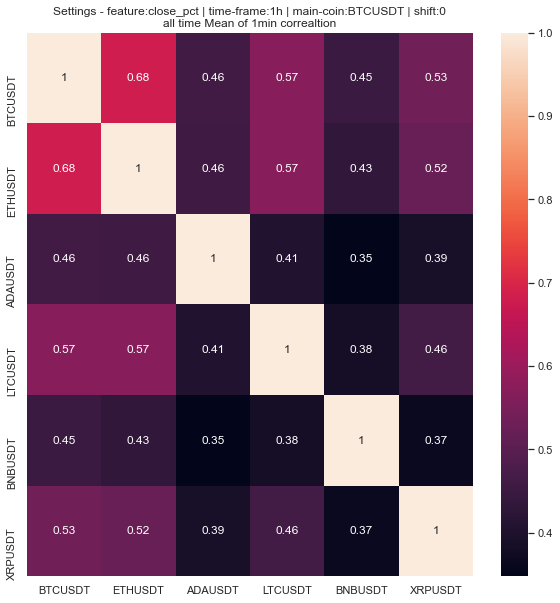

In [110]:
plot_heatmap(alltime_correlation_matrix_list.mean(axis=0), "all time Mean of 1min correaltion")

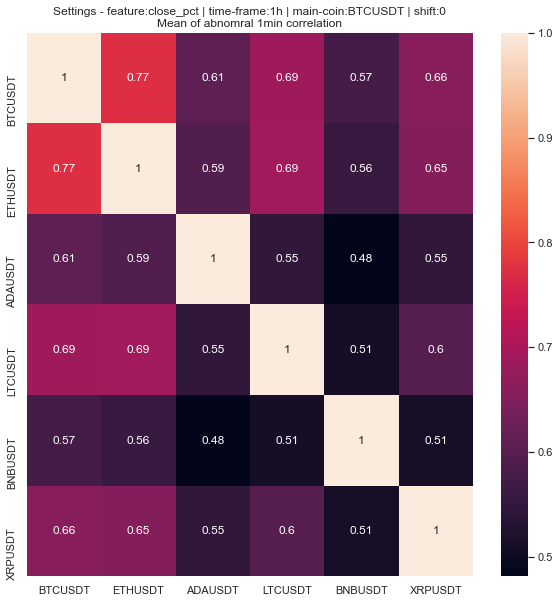

In [111]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0), "Mean of abnomral 1min correlation")

# Difference

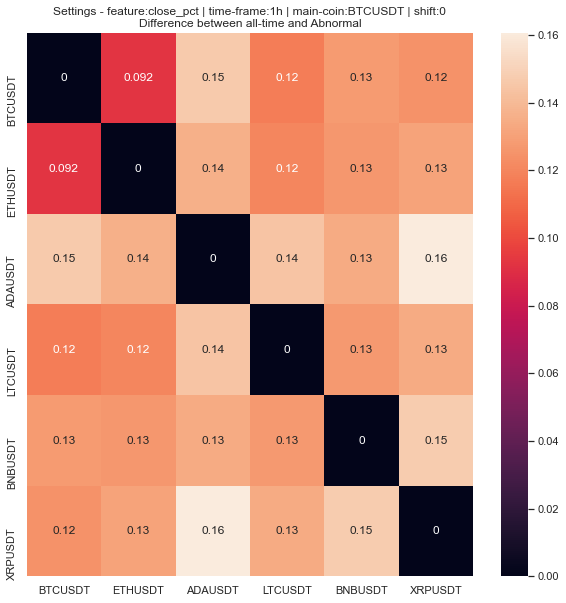

In [112]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0)-alltime_correlation_matrix_list.mean(axis=0), "Difference between all-time and Abnormal")

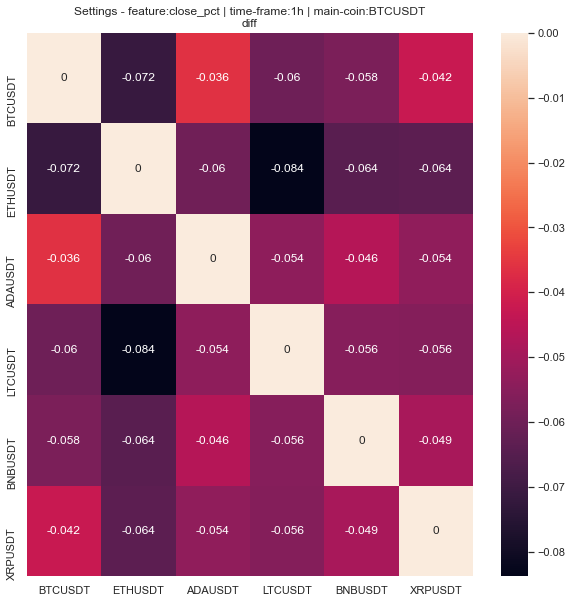

In [33]:
plot_heatmap(abnormal_correlation_matrix_list.std(axis=0)-alltime_correlation_matrix_list.std(axis=0), "diff")

# MI

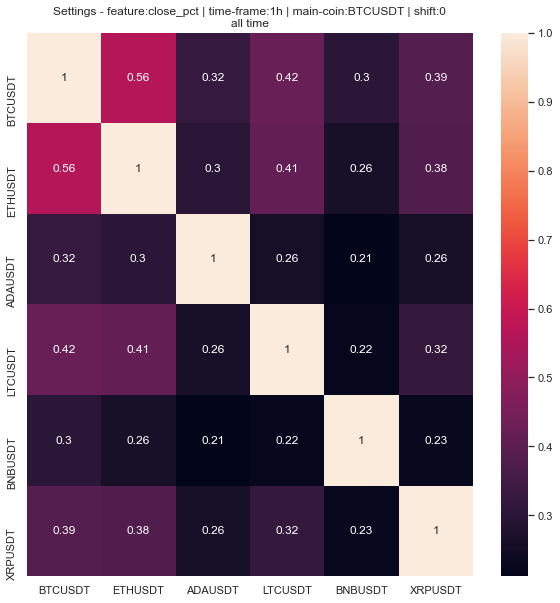

In [118]:
plot_heatmap(abnormal_mi_matrix_list.mean(axis=0), "all time")

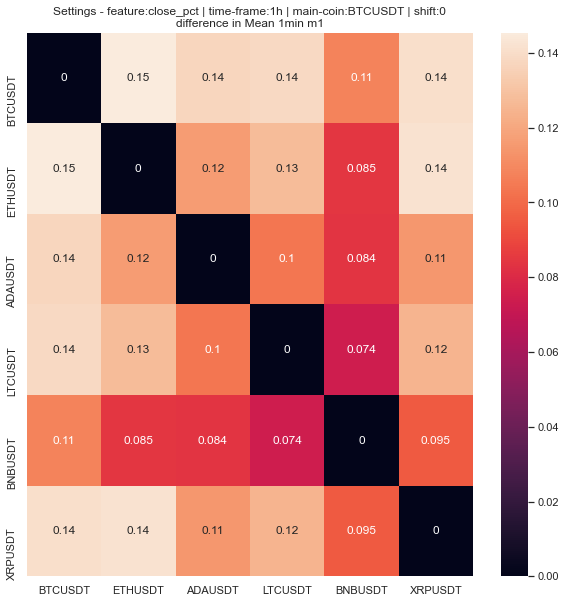

In [119]:
plot_heatmap(abnormal_mi_matrix_list.mean(axis=0) - alltime_mi_matrix_list.mean(axis=0), "difference in Mean 1min m1")